<a id=top></a>


## Exploratory Data Analysis of the COVID-19 Pandemic

#### &copy; 2020 Eleni Angelaki, Efthimios Kaxiras

<BR>

In [133]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import glob
from scipy.stats import norm
import scipy.stats as st

In [134]:
# extend pandas printing (optional)
pd.options.display.max_columns = 500  
pd.options.display.max_rows = 3000     
pd.options.display.max_colwidth = 200
pd.options.display.precision = 3

from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot')
%matplotlib inline

### Import Daily Data from:
https://ourworldindata.org/coronavirus-source-data 
(Sourced from the European Centre for Disease)

In [11]:
data = 'https://opendata.ecdc.europa.eu/covid19/casedistribution/csv'
daily_coronadata = pd.read_csv(data, index_col=False)
daily_coronadata.dropna(subset=['countryterritoryCode'], inplace=True) 
daily_coronadata.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
0,09/04/2020,9,4,2020,56,3,Afghanistan,AF,AFG,3.717e+07
1,08/04/2020,8,4,2020,30,4,Afghanistan,AF,AFG,3.717e+07
2,07/04/2020,7,4,2020,38,0,Afghanistan,AF,AFG,3.717e+07
3,06/04/2020,6,4,2020,29,2,Afghanistan,AF,AFG,3.717e+07
4,05/04/2020,5,4,2020,35,1,Afghanistan,AF,AFG,3.717e+07


#### Creating county case array `daily['GRC']`
We want to create a dictionary that associates country codes with their respective array of susceptible cases. This is called `daily` and to access the array we call, for example `daily['GRC']`.

In [233]:
daily = {}
for code in daily_coronadata['countryterritoryCode'].unique():
    daily_array = daily_coronadata[daily_coronadata['countryterritoryCode']==code]['cases'].to_numpy()[::-1]
    daily[code] = daily_array

In [234]:
daily['GRC']

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   1,   2,   1,   3,   0,   3,  22,
        13,  21,   7,  11,   6,   9,  34,  57,  38, 103,  21,  35,  31,
        46,  31,  35,  94,  71,  48,  78,  71,  74,  95,  95,  56, 102,
        61, 139,  99,  60,  62,  20,  77,  52])

#### If we are not sure about the country's code we can find it out using its name.

In [235]:
#
# Find the 3-letter acronym for each country
#
country = 'Spain'
daily_coronadata[daily_coronadata['countriesAndTerritories']==country].countryterritoryCode.iloc[0]

'ESP'

In [236]:
country = 'United_States_of_America'
daily_coronadata[daily_coronadata['countriesAndTerritories']==country].countryterritoryCode.iloc[0]

'USA'

In [237]:
country = 'Netherlands'
daily_coronadata[daily_coronadata['countriesAndTerritories']==country].countryterritoryCode.iloc[0]

'NLD'

In [238]:
# CHECKING : print all country codes
#daily_coronadata['countryterritoryCode'].unique()

In [239]:
# CHECKING : print all country names
#daily_coronadata['countriesAndTerritories'].unique()

#### Creating county populations array `pops['GRC']`

We want to create a dictionary that associates country codes with their respective populations. This is called `pops` and to access it we call, for example `pops['GRC']`.

In [240]:
# Create a dictionary with countrynames and population 
pops = {}
for code in daily_coronadata['countryterritoryCode'].unique():
    population = daily_coronadata[daily_coronadata['countryterritoryCode']==code].popData2018.iloc[0]
    pops[code] = population

In [241]:
# example print the population of Greece
pops['NLD']

17231017.0

In [242]:
# or France
pops['FRA']

66987244.0

In [243]:
# print dataframe subset
#daily_coronadata[daily_coronadata['countriesAndTerritories']=='France'].head()

#### Threshold for counting cases for each country.

We want to get the arrays from the point in time when cases started. This does not always coincide with the start of the We will do this manually by inspecting each array. See below for the numbers we have come up with:

In [244]:
t0 = {'CHN': 17, 'ITA': 53, 'ESP': 56, 'FRA': 57, 'NLD': 59, 'GRC': 58, 
      'DEU': 57, 'USA': 59, 'GRB': 59, 'SWE': 58, 'CHE':57, 'GBR':59}

In [245]:
t0['DEU']

57

In [247]:
start = t0['CHN']
print(daily['CHN'])
print(daily['CHN'][start:])

[   27     0     0    17     0    15     0     0     0     0     0     0
     0     0     0     0     0     4    17   136    19   151   140    97
   259   441   665   787  1753  1466  1740  1980  2095  2590  2812  3237
  3872  3727  3160  3418  2607  2974  2490  2028 15141  4156  2538  2007
  2052  1890  1750   394   891   826   647   218   515   410   439   329
   428   574   205   127   119   117   170   101    46    45    20    29
    24    22    19    22    25    43    23    44    99    52    65   138
    69    78   102    94   119   113    98    84    54   100    70    62
    48    67    56    86    86]
[    4    17   136    19   151   140    97   259   441   665   787  1753
  1466  1740  1980  2095  2590  2812  3237  3872  3727  3160  3418  2607
  2974  2490  2028 15141  4156  2538  2007  2052  1890  1750   394   891
   826   647   218   515   410   439   329   428   574   205   127   119
   117   170   101    46    45    20    29    24    22    19    22    25
    43    23    44 

In [159]:
# country = 'China'
# popul_CHN=daily_coronadata[daily_coronadata['countriesAndTerritories']==country].popData2018.iloc[0]
# daily_all_CHN = daily_coronadata[daily_coronadata['countriesAndTerritories']==country]['cases'].to_numpy()[::-1]
# daily_CHN = daily_all_CHN[17:67]
# daily_CHN
# #len(daily_CHN)

array([    4,    17,   136,    19,   151,   140,    97,   259,   441,
         665,   787,  1753,  1466,  1740,  1980,  2095,  2590,  2812,
        3237,  3872,  3727,  3160,  3418,  2607,  2974,  2490,  2028,
       15141,  4156,  2538,  2007,  2052,  1890,  1750,   394,   891,
         826,   647,   218,   515,   410,   439,   329,   428,   574,
         205,   127,   119,   117,   170])

In [10]:
# country = 'Italy'
# popul_ITA=daily_coronadata[daily_coronadata['countriesAndTerritories']==country].popData2018.iloc[0]
# daily_all_ITA = daily_coronadata[daily_coronadata['countriesAndTerritories']==country]['cases'].to_numpy()[::-1]
# daily_ITA=daily_all_ITA[53:]
# daily_ITA
# #len(daily_ITA)

array([  14,   62,   53,   97,   93,   78,  250,  238,  240,  561,  347,
        466,  587,  769,  778, 1247, 1492, 1797,  977, 2313, 2651, 2547,
       3497, 2823, 4000, 3526, 4207, 5322, 5986, 6557, 5560, 4789, 5249,
       5210, 6153, 5959, 5974, 5217, 4050, 4053, 4782, 4668, 4585, 4805,
       4316, 3599, 3039])

In [121]:
# country = 'Spain'
# popul_ESP=daily_coronadata[daily_coronadata['countriesAndTerritories']==country].popData2018.iloc[0]
# daily_all_ESP = daily_coronadata[daily_coronadata['countriesAndTerritories']==country]['cases'].to_numpy()[::-1]
# daily_ESP=daily_all_ESP[56:]
# daily_ESP
# #len(daily_ESP)

array([   1,    4,    5,   13,    9,   32,   17,   31,   37,   49,   61,
        113,   56,  159,  615,  435,  501,  864, 1227, 1522, 2000, 1438,
       1987, 2538, 3431, 2833, 4946, 3646, 4517, 6584, 7937, 8578, 7871,
       8189, 6549, 6398, 9222, 7719, 8102, 7472, 7026, 6023, 4273, 5478,
       6180])

In [12]:
# country = 'France'
# popul_FRA=daily_coronadata[daily_coronadata['countriesAndTerritories']==country].popData2018.iloc[0]
# daily_all_FRA = daily_coronadata[daily_coronadata['countriesAndTerritories']==country]['cases'].to_numpy()[::-1]
# daily_FRA=daily_all_FRA[57:]
# daily_FRA
# #len(daily_FRA)

array([   2,    3,   21,   19,   43,   30,   48,   34,   73,  138,  190,
        103,  410,  286,  372,  497,  595,  785,  838,  924, 1210, 1097,
       1404, 1861, 1617, 1847, 1559, 3838, 2446, 2931, 3922, 3809, 4611,
       2599, 4376, 7578, 4861, 2116, 5233, 4267, 1873, 3912, 3777])

In [13]:
# country = 'Netherlands'
# popul_NLD=daily_coronadata[daily_coronadata['countriesAndTerritories']==country].popData2018.iloc[0]
# daily_all_NLD = daily_coronadata[daily_coronadata['countriesAndTerritories']==country]['cases'].to_numpy()[::-1]
# daily_NLD=daily_all_NLD[59:]
# daily_NLD
# #len(daily_NLD)

array([   1,    1,    5,    6,    5,   10,   10,   44,   46,   60,   77,
         56,   61,  121,  111,  190,  155,  176,  278,  292,  346,  409,
        534,  637,  573,  545,  811,  852, 1019, 1172, 1159, 1104,  884,
        845, 1019, 1083, 1026,  904, 1224,  952,  777])

In [14]:
# country = 'Greece'
# popul_GRC=daily_coronadata[daily_coronadata['countriesAndTerritories']==country].popData2018.iloc[0]
# daily_all_GRC = daily_coronadata[daily_coronadata['countriesAndTerritories']==country]['cases'].to_numpy()[::-1]
# daily_GRC=daily_all_GRC[58:]
# daily_GRC
# #len(daily_GRC)

array([  1,   2,   1,   3,   0,   3,  22,  13,  21,   7,  11,   6,   9,
        34,  57,  38, 103,  21,  35,  31,  46,  31,  35,  94,  71,  48,
        78,  71,  74,  95,  95,  56, 102,  61, 139,  99,  60,  62,  20,
        77])

In [15]:
# country = 'Germany'
# popul_DEU=daily_coronadata[daily_coronadata['countriesAndTerritories']==country].popData2018.iloc[0]
# daily_all_DEU = daily_coronadata[daily_coronadata['countriesAndTerritories']==country]['cases'].to_numpy()[::-1]
# daily_DEU=daily_all_DEU[57:]
# daily_DEU
# #len(daily_DEU)

array([   2,    4,   26,   10,   54,   18,   28,   39,   66,  138,  284,
        163,   55,  237,  157,  271,  802,  693,  733, 1043, 1174, 1144,
       1042, 5940, 4049, 3276, 3311, 4438, 2342, 4954, 5780, 6294, 3965,
       4751, 4615, 5453, 6156, 6174, 6082, 5936, 3677, 3834, 4003])

In [16]:
# country = 'United_States_of_America'
# popul_USA=daily_coronadata[daily_coronadata['countriesAndTerritories']==country].popData2018.iloc[0]
# daily_all_USA = daily_coronadata[daily_coronadata['countriesAndTerritories']==country]['cases'].to_numpy()[::-1]
# daily_USA=daily_all_USA[59:]
# daily_USA
# #len(daily_USA)

array([    1,     6,     3,    20,    14,    22,    34,    74,   105,
          95,   121,   200,   271,   287,   351,   511,   777,   823,
         887,  1766,  2988,  4835,  5374,  7123,  8459, 11236,  8789,
       13963, 16797, 18695, 19979, 18360, 21595, 24998, 27103, 28819,
       32425, 34272, 25398, 30561, 30613])

In [17]:
# country = 'United_Kingdom'
# popul_GBR=daily_coronadata[daily_coronadata['countriesAndTerritories']==country].popData2018.iloc[0]
# daily_all_GBR = daily_coronadata[daily_coronadata['countriesAndTerritories']==country]['cases'].to_numpy()[::-1]
# daily_GBR=daily_all_GBR[59:]
# daily_GBR
# #len(daily_GBR)

array([   3,    2,    5,   13,    4,   11,   34,   30,   48,   43,   67,
         48,   52,   83,  134,  117,  433,  251,  152,  407,  680,  647,
        706, 1035,  665,  967, 1427, 1452, 2129, 2885, 2546, 2433, 2619,
       3009, 4324, 4244, 4450, 3735, 5903, 3802, 3634])

In [18]:
# country = 'Sweden'
# popul_SWE=daily_coronadata[daily_coronadata['countriesAndTerritories']==country].popData2018.iloc[0]
# daily_all_SWE = daily_coronadata[daily_coronadata['countriesAndTerritories']==country]['cases'].to_numpy()[::-1]
# daily_SWE=daily_all_SWE[58:]
# daily_SWE
# #len(daily_SWE)

array([  1,   5,   5,   1,   1,   1,   9,  11,  26,  76,  24,  42,  45,
        78, 136, 158, 155, 149, 108,  89,  46, 134, 122, 200, 123, 160,
       110, 256, 238, 296, 240, 401, 253, 328, 407, 512, 519, 612, 365,
       387, 376, 487])

In [19]:
# country = 'Switzerland'
# popul_CHE=daily_coronadata[daily_coronadata['countriesAndTerritories']==country].popData2018.iloc[0]
# daily_all_CHE = daily_coronadata[daily_coronadata['countriesAndTerritories']==country]['cases'].to_numpy()[::-1]
# daily_CHE=daily_all_CHE[57:]
# daily_CHE
# #len(daily_CHE)

array([   1,    0,    7,    4,    6,    6,    6,    7,   20,   30,  122,
         55,   68,   42,  116,  152,  212,  267,  238,  841,    0,  450,
        360,  878,  952, 1237,  894, 1044,  774,  925, 1000, 1390, 1048,
       1122, 1138,  696,  962, 1124, 1033,  974,  821,  552,  590])

In [149]:
# China has two thresholds so we manually set...
daily['CHN'] = daily['CHN'][:67]

In [160]:
# def plot_country(country, data, thresh):
#     plt.figure(figsize=(15,5))
#     data = data[thresh:]
#     x = np.arange(len(data))
#     plt.title(country)
#     plt.plot(x, data);
    
def plot_countries(country_codes, daily, thresh, title_to_save):
    fig = plt.figure(figsize=(6,5))
    plt.title('Covid19 cases by country')
    for code in country_codes:
        data = daily[code][thresh[code]:]
        x = np.arange(len(data))
        plt.plot(x, data, label=code);
    plt.legend()
    #fig.savefig(title_to_save, format='png')
    
def plot_countries_by_popul(country_codes, daily, thresh, title_to_save, pops_array):
    fig = plt.figure(figsize=(6,5))
    plt.title('Covid19 cases by country')
    for code in country_codes:
        data = daily[code][thresh[code]:]
        data = data/pops_array[code]*1.0e6
        x = np.arange(len(data))
        plt.plot(x, data, label=code);
    plt.legend()
    #fig.savefig(title_to_save, format='png')

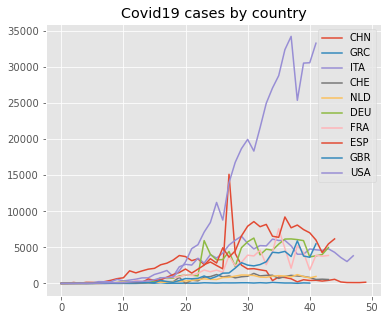

In [161]:
countries_to_plot = ['CHN','GRC','ITA','CHE','NLD','DEU','FRA','ESP','GBR','USA']
plot_countries(countries_to_plot, daily, t0, 'Total_10.png')

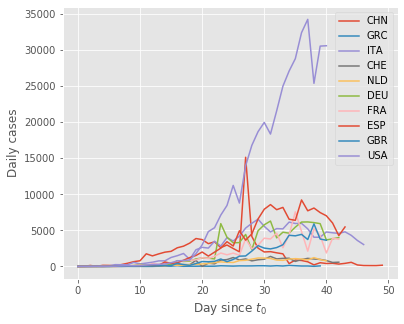

In [24]:
#country, data = country_data('Greece', coronadata, 0)

# fig=plt.figure(figsize=(6,5))
# plt.plot(daily_CHN,label='CHN')
# plt.plot(daily_GRC,label='GRC')
# plt.plot(daily_ITA,label='ITA')
# plt.plot(daily_CHE,label='CHE')
# plt.plot(daily_NLD,label='NLD')
# plt.plot(daily_DEU,label='DEU')
# plt.plot(daily_FRA,label='FRA')
# plt.plot(daily_ESP,label='ESP')
# plt.plot(daily_GBR,label='GBR')
# plt.plot(daily_USA,label='USA')

# #plt.plot(daily_SWE,label='SWE')
# plt.xlabel('Day since $t_0$')
# plt.ylabel('Daily cases')

# plt.legend()
# fig.savefig('Total_10.png',format='png')

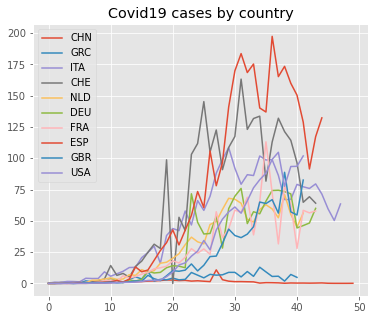

In [162]:
countries_to_plot = ['CHN','GRC','ITA','CHE','NLD','DEU','FRA','ESP','GBR','USA']
plot_countries_by_popul(countries_to_plot, daily, t0, 'Total_scale_10.png', pops)

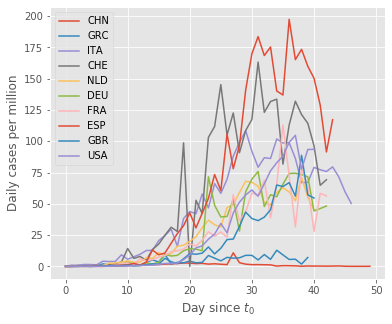

In [25]:
# #country, data = country_data('Greece', coronadata, 0)
# fig=plt.figure(figsize=(6,5))
# plt.plot(daily_CHN/popul_CHN*1.0e6,label='CHN')
# plt.plot(daily_GRC/popul_GRC*1.0e6,label='GRC')
# plt.plot(daily_ITA/popul_ITA*1.0e6,label='ITA')
# plt.plot(daily_CHE/popul_CHE*1.0e6,label='CHE')
# plt.plot(daily_NLD/popul_NLD*1.0e6,label='NLD')
# plt.plot(daily_DEU/popul_DEU*1.0e6,label='DEU')
# plt.plot(daily_FRA/popul_FRA*1.0e6,label='FRA')
# plt.plot(daily_ESP/popul_ESP*1.0e6,label='ESP')
# plt.plot(daily_GBR/popul_GBR*1.0e6,label='GBR')
# plt.plot(daily_USA/popul_USA*1.0e6,label='USA')

# #plt.plot(daily_SWE/popul_SWE*1.0e6,label='SWE')

# plt.xlabel('Day since $t_0$')
# plt.ylabel('Daily cases per million')


# plt.legend()
# fig.savefig('Total_scale_10.png',format='png')

In [163]:
def daily_fit(t,t1,dt,dn):
    a=0.25
    t2=t1+dt
    return dn*(1./(1.+np.exp(-a*(t-t1))) - 1./(1.+np.exp(-a*(t-t2))))

In [110]:
from scipy.optimize import curve_fit

In [204]:
file_name = f'Total_{code}.png'
type(file_name)

str

In [211]:
# 
# Fit and print country=code data and parapmeters
#

def fit_and_print(code, daily, thresh, pops_array):
    popul=pops_array[code]  # popul=popul_ESP
    fdat = daily[code][thresh[code]:]  #fdat = daily_ESP
    xdat = np.arange(len(fdat))

    popt, pcov = curve_fit(daily_fit, xdat, fdat)
    print(popt)
    t1=popt[0]
    dt=popt[1]
    dn=popt[2]

    #a1= 0.25    
    #a2= 0.25  
    #t1= 25      
    #dt= 13     
    #dn= 13000

    ffit=daily_fit(xdat, t1, dt, dn)

    rmsfit=np.sqrt(np.sum((ffit-fdat)**2)/len(fdat))
    print(rmsfit/dn*100)

    cumm_dat=np.zeros(len(fdat))
    cumm_fit=np.zeros(len(fdat))
    cumm_dat[0]=fdat[0]
    cumm_fit[0]=ffit[0]
    for i in range (1,len(fdat)):
        cumm_dat[i]=cumm_dat[i-1]+fdat[i]
        cumm_fit[i]=cumm_fit[i-1]+ffit[i]

    fig=plt.figure(figsize=(15,5))
    plt.scatter(xdat,fdat)
    plt.plot(xdat,ffit,'g')
    # plt.title('ESP: 4/8/2020')
    plt.title(f'{code}: 4/8/2020')
    plt.ylabel('Daily cases')
    plt.xlabel('$t-t_0$ (days)')
    plt.show();
    #fig.savefig('Daily_ESP.png',format='png')
    filename = f'Daily_{code}.png'
    fig.savefig(filename,format='png')

    T_ext=30
    cumm_dat=np.zeros(len(fdat))
    xdat_ext = np.arange(len(fdat)+T_ext)
    ffit_ext=daily_fit(xdat_ext, t1, dt, dn)
    cumm_fit=np.zeros(len(fdat)+T_ext)
    cumm_dat[0]=fdat[0]
    cumm_fit[0]=ffit[0]
    for i in range (1,len(fdat)):
        cumm_dat[i]=cumm_dat[i-1]+fdat[i]
    for i in range (1,len(fdat)+T_ext):
        cumm_fit[i]=cumm_fit[i-1]+ffit_ext[i]

    fig=plt.figure(figsize=(15,5))
    plt.scatter(xdat,cumm_dat)
    plt.plot(xdat_ext,cumm_fit,'g')
    plt.title(f'{code}: 4/8/2020') # plt.title('ESP: 4/8/2020')
    plt.ylabel('Total cases')
    plt.xlabel('$t-t_0$ (days)')
    plt.show();
    filename = f'Total_{code}.png'
    fig.savefig(filename,format='png')
    #fig.savefig('Total_ESP.png',format='png')

    print(cumm_fit[-1])

#### For each country code

[   27.24035456    16.10286703 10539.90416677]
6.417046273237774


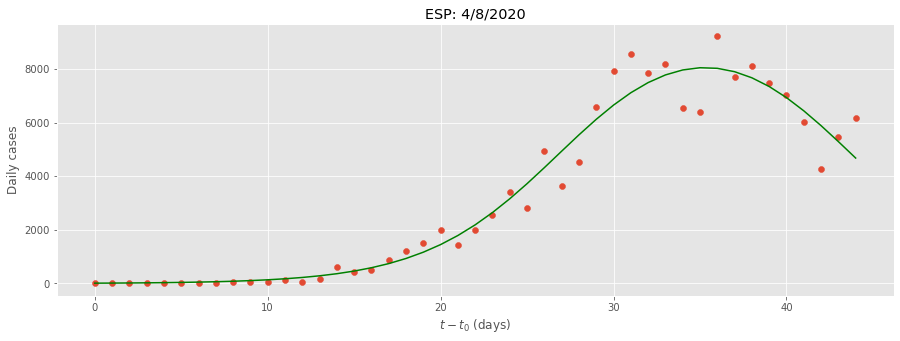

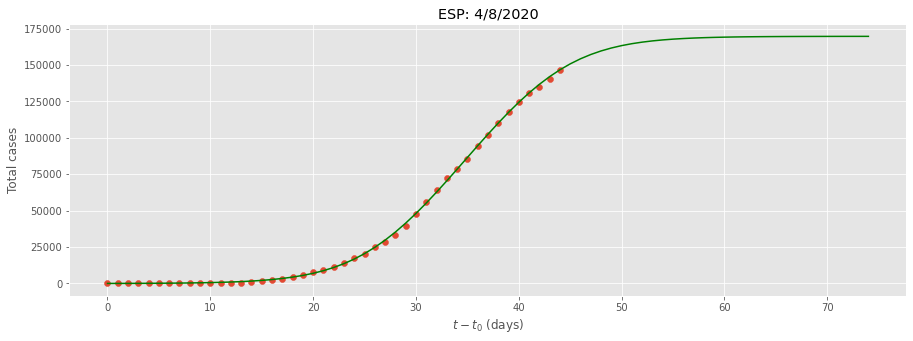

169665.40709969486


In [212]:
fit_and_print('ESP', daily, t0, pops)

[   27.71972929    14.40528413 11371.07324673]
5.555049769763316


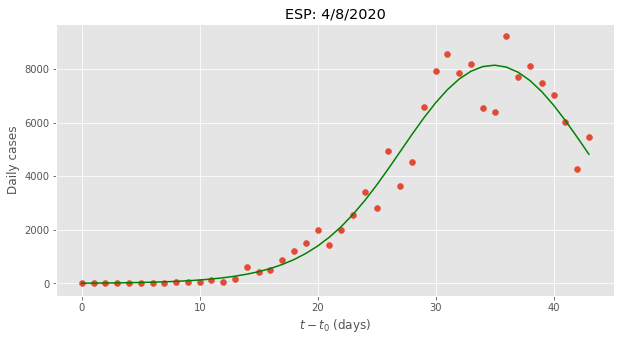

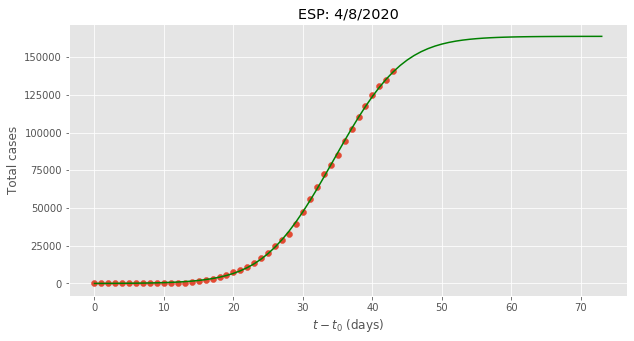

163748.16544861038


In [29]:
# # ESP data and parapmeters
# popul=popul_ESP
# fdat = daily_ESP
# xdat = np.arange(len(fdat))
    
# popt, pcov = curve_fit(daily_fit, xdat, fdat)
# print(popt)
# t1=popt[0]
# dt=popt[1]
# dn=popt[2]

# #a1= 0.25    
# #a2= 0.25  
# #t1= 25      
# #dt= 13     
# #dn= 13000

# ffit=daily_fit(xdat, t1, dt, dn)

# rmsfit=np.sqrt(np.sum((ffit-fdat)**2)/len(fdat))
# print(rmsfit/dn*100)

# cumm_dat=np.zeros(len(fdat))
# cumm_fit=np.zeros(len(fdat))
# cumm_dat[0]=fdat[0]
# cumm_fit[0]=ffit[0]
# for i in range (1,len(fdat)):
#     cumm_dat[i]=cumm_dat[i-1]+fdat[i]
#     cumm_fit[i]=cumm_fit[i-1]+ffit[i]
    
# fig=plt.figure(figsize=(10,5))
# plt.scatter(xdat,fdat)
# plt.plot(xdat,ffit,'g')
# plt.title('ESP: 4/8/2020')
# plt.ylabel('Daily cases')
# plt.xlabel('$t-t_0$ (days)')
# plt.show();
# fig.savefig('Daily_ESP.png',format='png')

# T_ext=30
# cumm_dat=np.zeros(len(fdat))
# xdat_ext = np.arange(len(fdat)+T_ext)
# ffit_ext=daily_fit(xdat_ext, t1, dt, dn)
# cumm_fit=np.zeros(len(fdat)+T_ext)
# cumm_dat[0]=fdat[0]
# cumm_fit[0]=ffit[0]
# for i in range (1,len(fdat)):
#     cumm_dat[i]=cumm_dat[i-1]+fdat[i]
# for i in range (1,len(fdat)+T_ext):
#     cumm_fit[i]=cumm_fit[i-1]+ffit_ext[i]

# fig=plt.figure(figsize=(10,5))
# plt.scatter(xdat,cumm_dat)
# plt.plot(xdat_ext,cumm_fit,'g')
# plt.title('ESP: 4/8/2020')
# plt.ylabel('Total cases')
# plt.xlabel('$t-t_0$ (days)')
# plt.show();
# fig.savefig('Total_ESP.png',format='png')

# print(cumm_fit[-1])

[  21.28883065   25.79653971 5969.65017197]
8.14905400498398


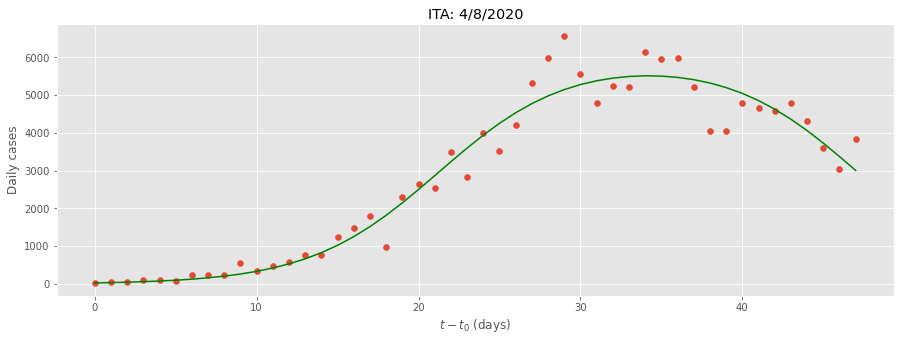

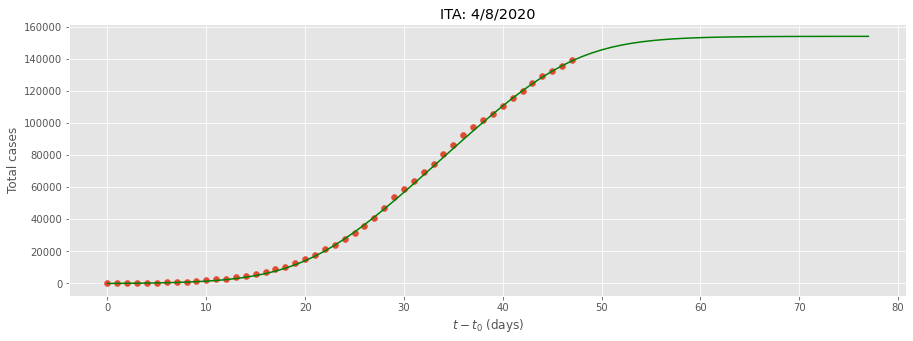

153882.23578511598


In [213]:
fit_and_print('ITA', daily, t0, pops)

[  21.46679331   24.8404441  6079.04506587]
7.762425914516117


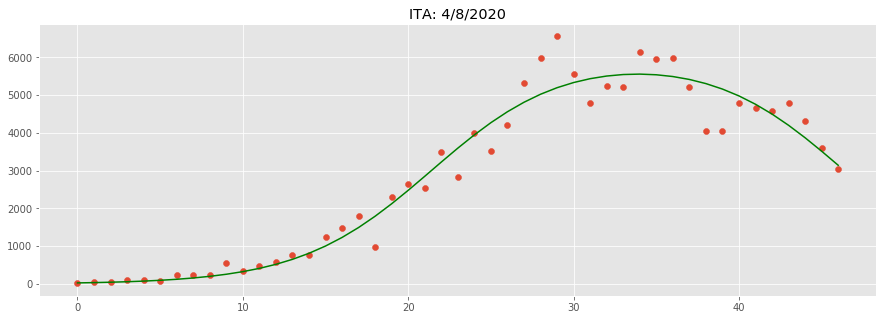

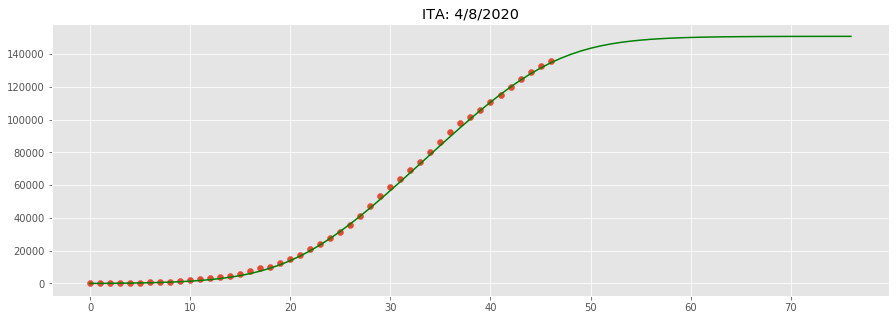

150893.8872470651


In [90]:
# # ITA data and parapmeters

# fdat = daily_ITA
# xdat = np.arange(len(fdat))
    
# popt, pcov = curve_fit(daily_fit, xdat, fdat)
# print(popt)
# t1=popt[0]
# dt=popt[1]
# dn=popt[2]

# #a1= 0.25    
# #a2= 0.25    
# #t1= 20      
# #dt= 25      
# #dn= 6000    

# ffit=daily_fit(xdat, t1, dt, dn)

# rmsfit=np.sqrt(np.sum((ffit-fdat)**2)/len(fdat))
# print(rmsfit/dn*100)

# plt.figure(figsize=(15,5))
# plt.scatter(xdat,fdat)
# plt.plot(xdat,ffit,'g')
# plt.title('ITA: 4/8/2020')
# plt.show();

# T_ext=30
# cumm_dat=np.zeros(len(fdat))
# xdat_ext = np.arange(len(fdat)+T_ext)
# ffit_ext=daily_fit(xdat_ext, t1, dt, dn)
# cumm_fit=np.zeros(len(fdat)+T_ext)
# cumm_dat[0]=fdat[0]
# cumm_fit[0]=ffit[0]
# for i in range (1,len(fdat)):
#     cumm_dat[i]=cumm_dat[i-1]+fdat[i]
# for i in range (1,len(fdat)+T_ext):
#     cumm_fit[i]=cumm_fit[i-1]+ffit_ext[i]
# plt.figure(figsize=(15,5))
# plt.scatter(xdat,cumm_dat)
# plt.plot(xdat_ext,cumm_fit,'g')
# plt.title('ITA: 4/8/2020')
# plt.show();
# print(cumm_fit[-1])

[  23.23876662   21.71242835 1211.63211202]
7.1532016985881945


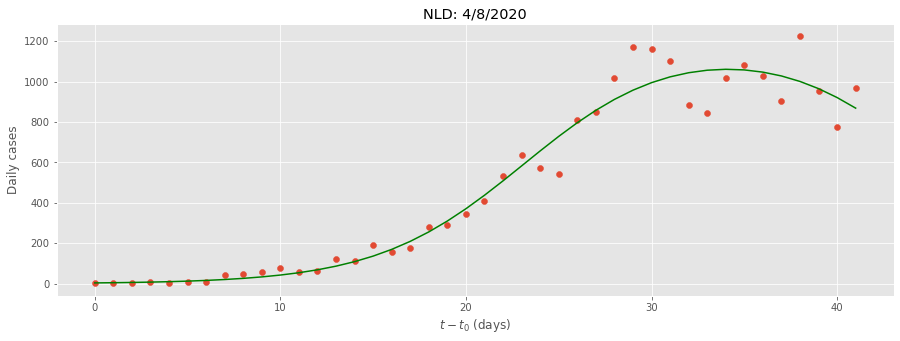

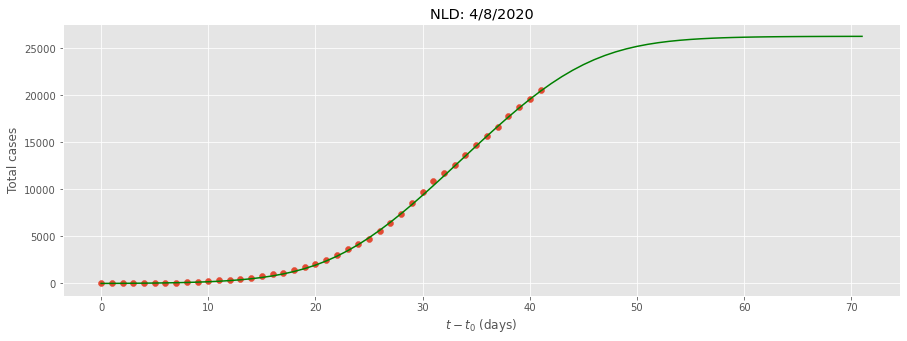

26288.453742261805


In [218]:
fit_and_print('NLD', daily, t0, pops)

[  23.49953202   20.08285504 1253.24807621]
6.813959674949496


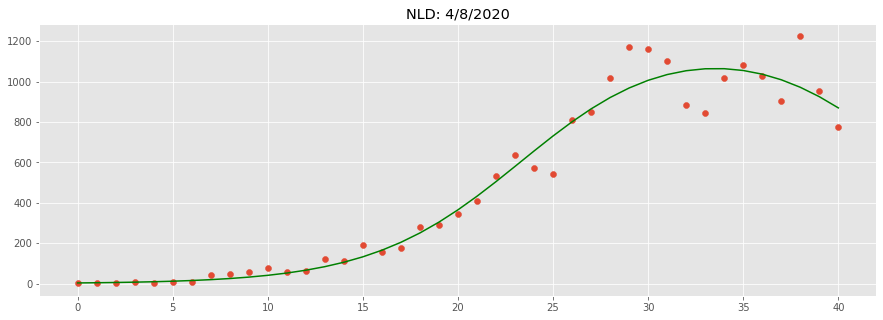

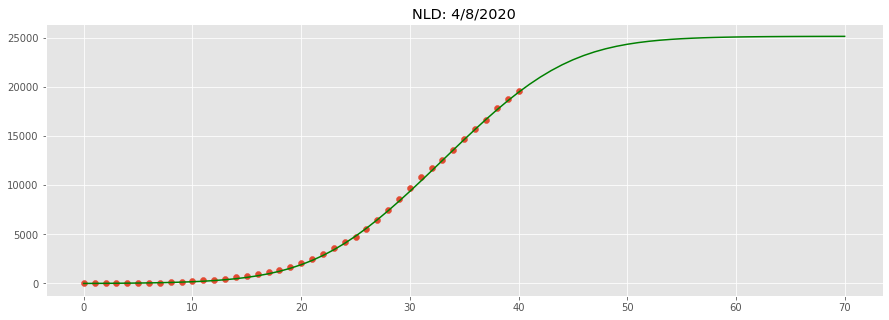

25150.568151725824


In [88]:
# # NDL data and parapmeters

# fdat = daily_NLD
# xdat = np.arange(len(fdat))
    
# popt, pcov = curve_fit(daily_fit, xdat, fdat)
# print(popt)
# t1=popt[0]
# dt=popt[1]
# dn=popt[2] 

# ffit=daily_fit(xdat, t1, dt, dn)

# rmsfit=np.sqrt(np.sum((ffit-fdat)**2)/len(fdat))
# print(rmsfit/dn*100)

# plt.figure(figsize=(15,5))
# plt.scatter(xdat,fdat)
# plt.plot(xdat,ffit,'g')
# plt.title('NLD: 4/8/2020')
# plt.show();

# T_ext=30
# cumm_dat=np.zeros(len(fdat))
# xdat_ext = np.arange(len(fdat)+T_ext)
# ffit_ext=daily_fit(xdat_ext, t1, dt, dn)
# cumm_fit=np.zeros(len(fdat)+T_ext)
# cumm_dat[0]=fdat[0]
# cumm_fit[0]=ffit[0]
# for i in range (1,len(fdat)):
#     cumm_dat[i]=cumm_dat[i-1]+fdat[i]
# for i in range (1,len(fdat)+T_ext):
#     cumm_fit[i]=cumm_fit[i-1]+ffit_ext[i]
# plt.figure(figsize=(15,5))
# plt.scatter(xdat,cumm_dat)
# plt.plot(xdat_ext,cumm_fit,'g')
# plt.title('NLD: 4/8/2020')
# plt.show();

# print(cumm_fit[-1])

[  24.16340978   21.6975792  6225.52543328]
13.289610800418036


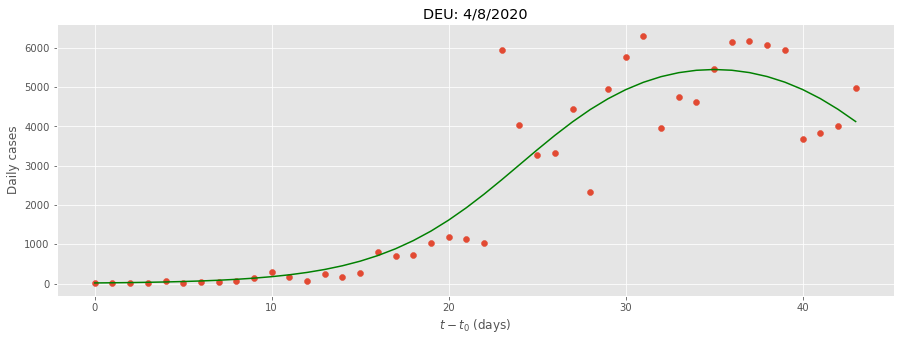

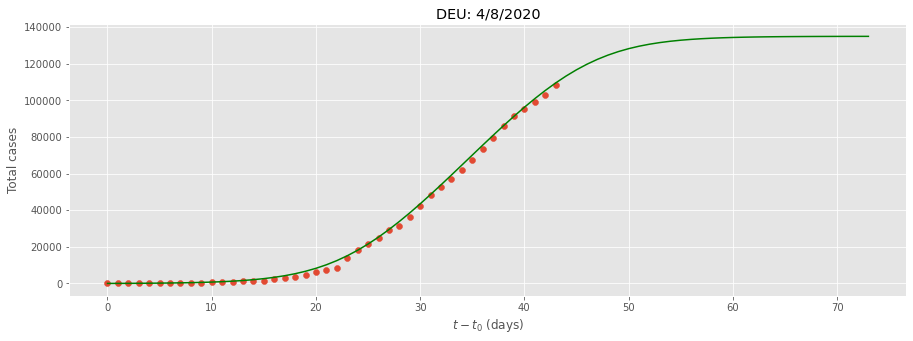

135002.29232567403


In [220]:
fit_and_print('DEU', daily, t0, pops)

[  24.47629865   19.90944859 6477.42508171]
12.688642793080113


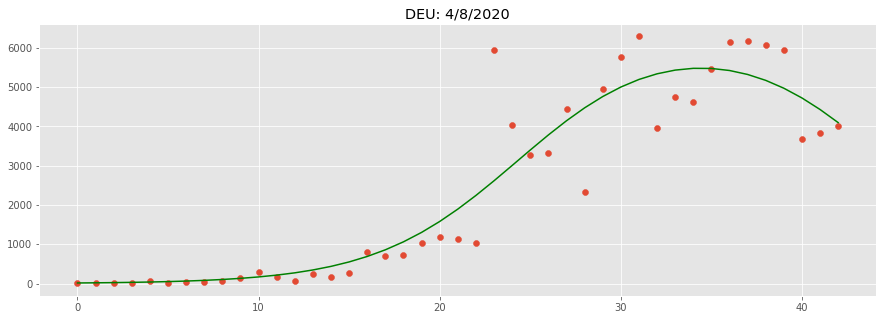

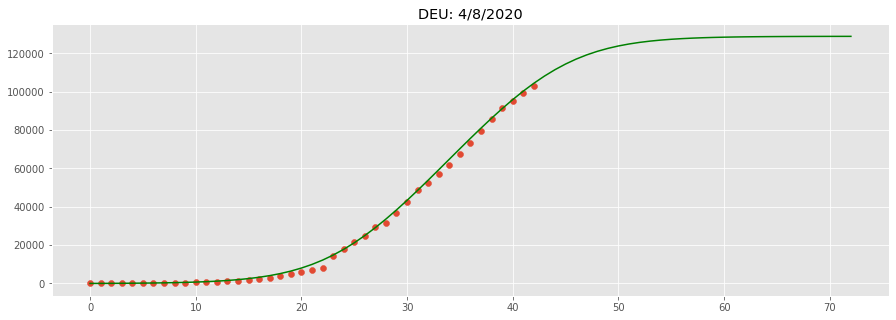

128889.43815341323


In [91]:
# DEU data and parapmeters

# fdat = daily_DEU
# xdat = np.arange(len(fdat))
    
# popt, pcov = curve_fit(daily_fit, xdat, fdat)
# print(popt)
# t1=popt[0]
# dt=popt[1]
# dn=popt[2]

# ffit=daily_fit(xdat, t1, dt, dn)

# rmsfit=np.sqrt(np.sum((ffit-fdat)**2)/len(fdat))
# print(rmsfit/dn*100)

# plt.figure(figsize=(15,5))
# plt.scatter(xdat,fdat)
# plt.plot(xdat,ffit,'g')
# plt.title('DEU: 4/8/2020')
# plt.show();

# T_ext=30
# cumm_dat=np.zeros(len(fdat))
# xdat_ext = np.arange(len(fdat)+T_ext)
# ffit_ext=daily_fit(xdat_ext, t1, dt, dn)
# cumm_fit=np.zeros(len(fdat)+T_ext)
# cumm_dat[0]=fdat[0]
# cumm_fit[0]=ffit[0]
# for i in range (1,len(fdat)):
#     cumm_dat[i]=cumm_dat[i-1]+fdat[i]
# for i in range (1,len(fdat)+T_ext):
#     cumm_fit[i]=cumm_fit[i-1]+ffit_ext[i]
# plt.figure(figsize=(15,5))
# plt.scatter(xdat,cumm_dat)
# plt.plot(xdat_ext,cumm_fit,'g')
# plt.title('DEU: 4/8/2020')
# plt.show();

# print(cumm_fit[-1])

[  26.53111077   18.22645701 5401.2100863 ]
14.697169424713572


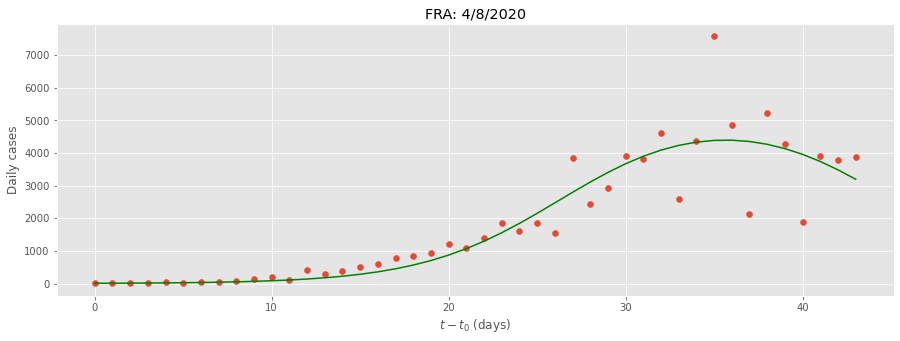

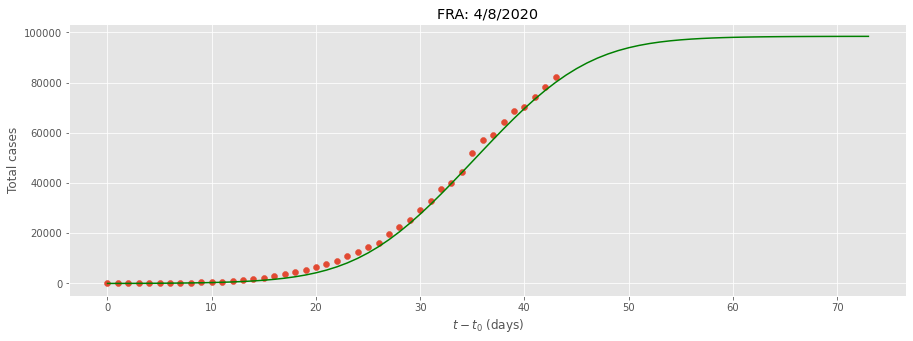

98404.02156029762


In [221]:
fit_and_print('FRA', daily, t0, pops)

[  27.16151636   15.80255266 5892.64099413]
13.4442824745357


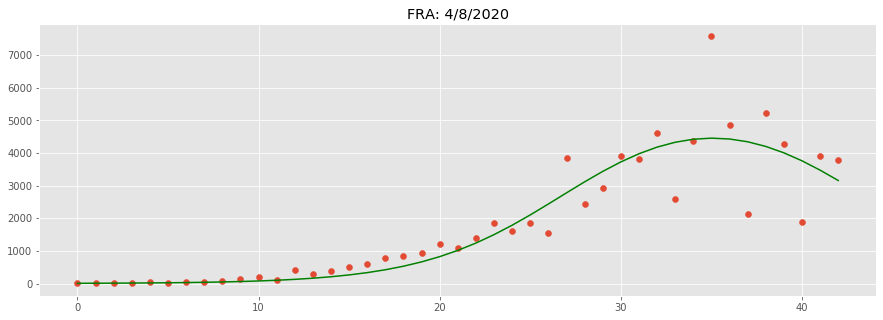

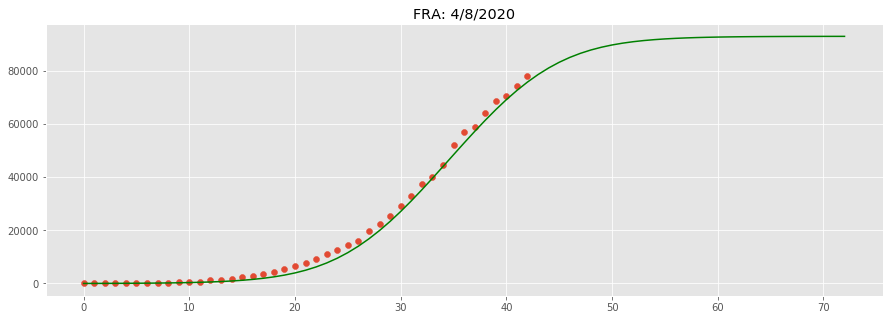

93081.58263787911


In [92]:
# FRA data and parapmeters

# fdat = daily_FRA
# xdat = np.arange(len(fdat))
    
# popt, pcov = curve_fit(daily_fit, xdat, fdat)
# print(popt)

# t1=popt[0]
# dt=popt[1]
# dn=popt[2]

# ffit=daily_fit(xdat, t1, dt, dn)

# rmsfit=np.sqrt(np.sum((ffit-fdat)**2)/len(fdat))
# print(rmsfit/dn*100)

# plt.figure(figsize=(15,5))
# plt.scatter(xdat,fdat)
# plt.plot(xdat,ffit,'g')
# plt.title('FRA: 4/8/2020')
# plt.show();

# T_ext=30
# cumm_dat=np.zeros(len(fdat))
# xdat_ext = np.arange(len(fdat)+T_ext)
# ffit_ext=daily_fit(xdat_ext, t1, dt, dn)
# cumm_fit=np.zeros(len(fdat)+T_ext)
# cumm_dat[0]=fdat[0]
# cumm_fit[0]=ffit[0]
# for i in range (1,len(fdat)):
#     cumm_dat[i]=cumm_dat[i-1]+fdat[i]
# for i in range (1,len(fdat)+T_ext):
#     cumm_fit[i]=cumm_fit[i-1]+ffit_ext[i]
# plt.figure(figsize=(15,5))
# plt.scatter(xdat,cumm_dat)
# plt.plot(xdat_ext,cumm_fit,'g')
# plt.title('FRA: 4/8/2020')
# plt.show();

# print(cumm_fit[-1])

[17.15781908 25.43510001 85.95073359]
25.436343411974576


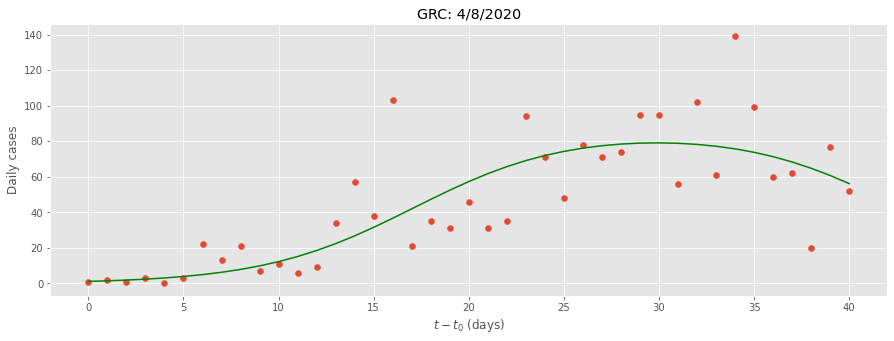

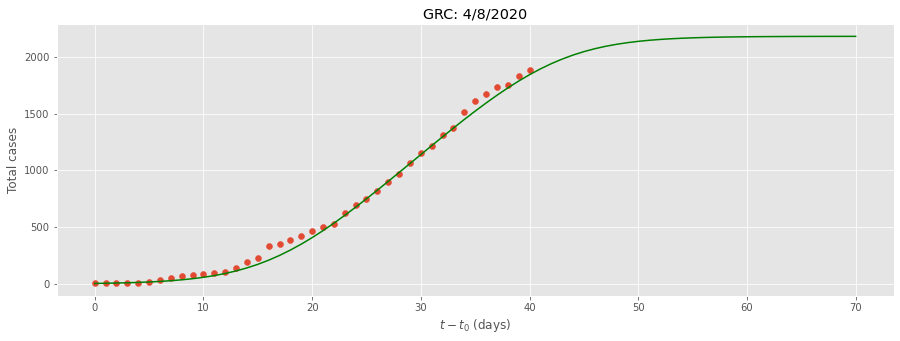

2181.7284697637792


In [222]:
fit_and_print('GRC', daily, t0, pops)

[17.05557696 25.98430815 85.25127452]
25.947703744300497


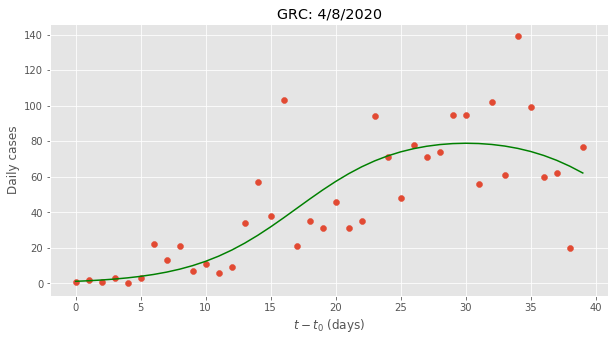

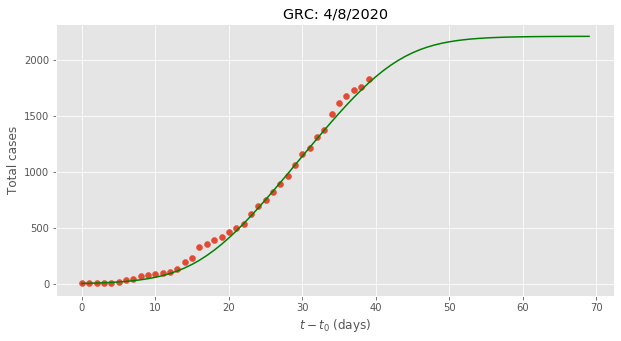

2210.5503754351844


In [31]:
# GRC data and parapmeters

# fdat = daily_GRC
# xdat = np.arange(len(fdat))
    
# popt, pcov = curve_fit(daily_fit, xdat, fdat)
# print(popt)
# t1=popt[0]
# dt=popt[1]
# dn=popt[2]

# ffit=daily_fit(xdat, t1, dt, dn)

# rmsfit=np.sqrt(np.sum((ffit-fdat)**2)/len(fdat))
# print(rmsfit/dn*100)

# fig=plt.figure(figsize=(10,5))
# plt.scatter(xdat,fdat)
# plt.plot(xdat,ffit,'g')
# plt.title('GRC: 4/8/2020')
# plt.ylabel('Daily cases')
# plt.xlabel('$t-t_0$ (days)')
# plt.show();
# fig.savefig('Daily_GRC.png',format='png')


# T_ext=30
# cumm_dat=np.zeros(len(fdat))
# xdat_ext = np.arange(len(fdat)+T_ext)
# ffit_ext=daily_fit(xdat_ext, t1, dt, dn)
# cumm_fit=np.zeros(len(fdat)+T_ext)
# cumm_dat[0]=fdat[0]
# cumm_fit[0]=ffit[0]
# for i in range (1,len(fdat)):
#     cumm_dat[i]=cumm_dat[i-1]+fdat[i]
# for i in range (1,len(fdat)+T_ext):
#     cumm_fit[i]=cumm_fit[i-1]+ffit_ext[i]
    
# fig=plt.figure(figsize=(10,5))
# plt.scatter(xdat,cumm_dat)
# plt.plot(xdat_ext,cumm_fit,'g')
# plt.title('GRC: 4/8/2020')
# plt.ylabel('Total cases')
# plt.xlabel('$t-t_0$ (days)')
# plt.show();
# fig.savefig('Total_GRC.png',format='png')


# print(cumm_fit[-1])

[  18.51384152   11.06971873 7344.8417632 ]
23.201159586312993


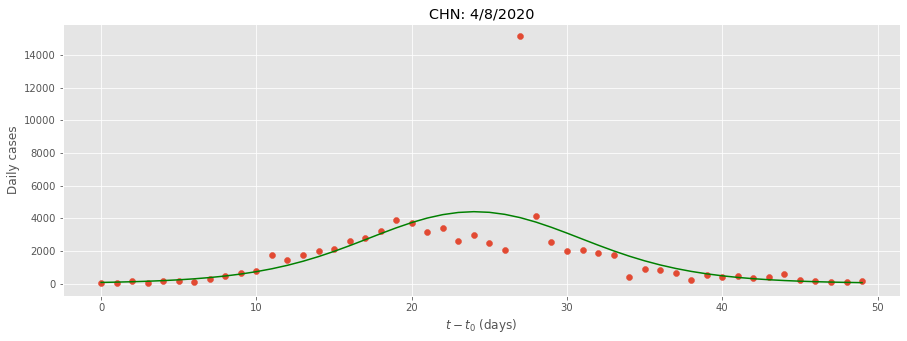

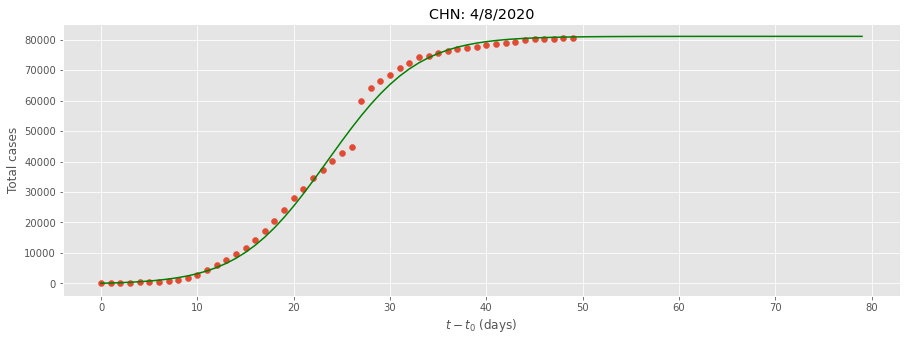

81069.52536251592


In [223]:
fit_and_print('CHN', daily, t0, pops)

[  18.51384152   11.06971873 7344.8417632 ]
23.201159586312993


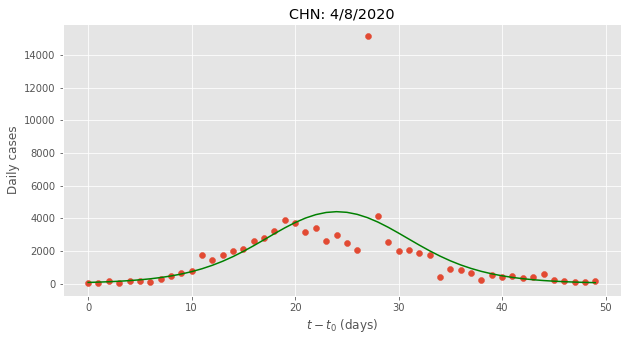

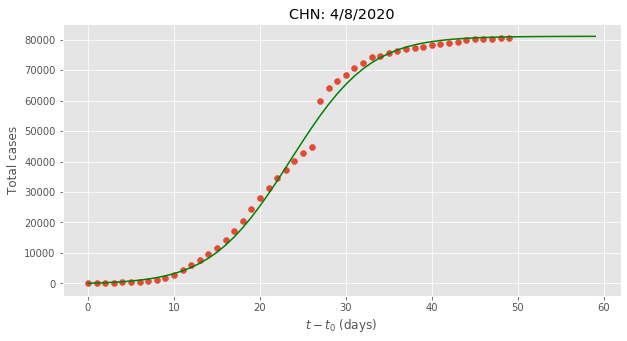

81054.12499658574


In [32]:
# # CHN data and parapmeters

# fdat = daily_CHN
# xdat = np.arange(len(fdat))
    
# popt, pcov = curve_fit(daily_fit, xdat, fdat)
# print(popt)
# t1=popt[0]
# dt=popt[1]
# dn=popt[2]

# ffit=daily_fit(xdat, t1, dt, dn)

# rmsfit=np.sqrt(np.sum((ffit-fdat)**2)/len(fdat))
# print(rmsfit/dn*100)

# fig=plt.figure(figsize=(10,5))
# plt.scatter(xdat,fdat)
# plt.plot(xdat,ffit,'g')
# plt.title('CHN: 4/8/2020')
# plt.ylabel('Daily cases')
# plt.xlabel('$t-t_0$ (days)')
# plt.show();
# fig.savefig('Daily_CHN.png',format='png')


# T_ext=10
# cumm_dat=np.zeros(len(fdat))
# xdat_ext = np.arange(len(fdat)+T_ext)
# ffit_ext=daily_fit(xdat_ext, t1, dt, dn)
# cumm_fit=np.zeros(len(fdat)+T_ext)
# cumm_dat[0]=fdat[0]
# cumm_fit[0]=ffit[0]
# for i in range (1,len(fdat)):
#     cumm_dat[i]=cumm_dat[i-1]+fdat[i]
# for i in range (1,len(fdat)+T_ext):
#     cumm_fit[i]=cumm_fit[i-1]+ffit_ext[i]
    
# fig=plt.figure(figsize=(10,5))
# plt.scatter(xdat,cumm_dat)
# plt.plot(xdat_ext,cumm_fit,'g')
# plt.title('CHN: 4/8/2020')
# plt.ylabel('Total cases')
# plt.xlabel('$t-t_0$ (days)')
# #plt.legend()
# plt.show();
# fig.savefig('Total_CHN.png',format='png')


# print(cumm_fit[-1])

[2.86338571e+01 1.90297629e+04 3.34784508e+04]
4.704680276558523


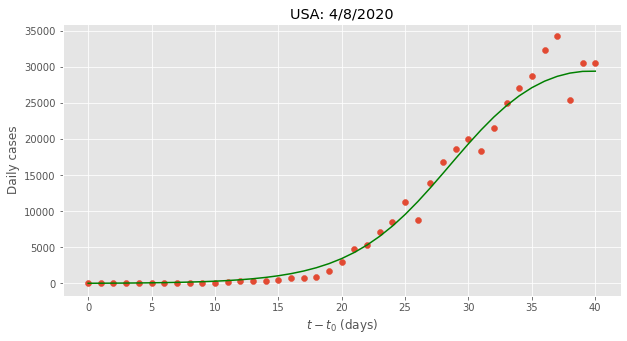

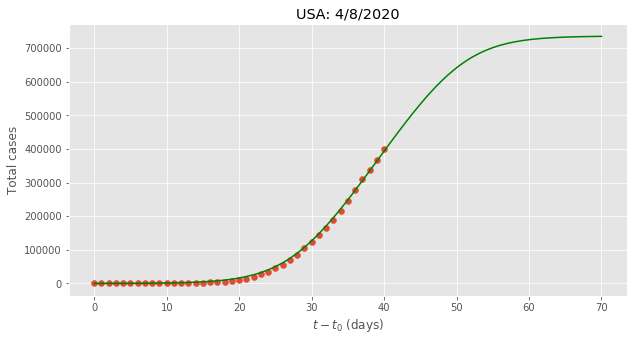

735511.0110806716


In [36]:
# USA data and parapmeters

fdat = daily_USA
xdat = np.arange(len(fdat))
    
popt, pcov = curve_fit(daily_fit, xdat, fdat)
print(popt)
t1=popt[0]
dt=popt[1]
dn=popt[2]

dt=22

ffit=daily_fit(xdat, t1, dt, dn)

rmsfit=np.sqrt(np.sum((ffit-fdat)**2)/len(fdat))
print(rmsfit/dn*100)

fig=plt.figure(figsize=(10,5))
plt.scatter(xdat,fdat)
plt.plot(xdat,ffit,'g')
plt.title('USA: 4/8/2020')
plt.ylabel('Daily cases')
plt.xlabel('$t-t_0$ (days)')
plt.show();
fig.savefig('Daily_USA.png',format='png')


T_ext=30
cumm_dat=np.zeros(len(fdat))
xdat_ext = np.arange(len(fdat)+T_ext)
ffit_ext=daily_fit(xdat_ext, t1, dt, dn)
cumm_fit=np.zeros(len(fdat)+T_ext)
cumm_dat[0]=fdat[0]
cumm_fit[0]=ffit[0]
for i in range (1,len(fdat)):
    cumm_dat[i]=cumm_dat[i-1]+fdat[i]
for i in range (1,len(fdat)+T_ext):
    cumm_fit[i]=cumm_fit[i-1]+ffit_ext[i]
    
fig=plt.figure(figsize=(10,5))
plt.scatter(xdat,cumm_dat)
plt.plot(xdat_ext,cumm_fit,'g')
plt.ylabel('Total cases')
plt.xlabel('$t-t_0$ (days)')
plt.title('USA: 4/8/2020')
plt.show();
fig.savefig('Total_USA.png',format='png')


print(cumm_fit[-1])

[  29.85438007 7416.44254714 5054.20981681]
7.954568926520158


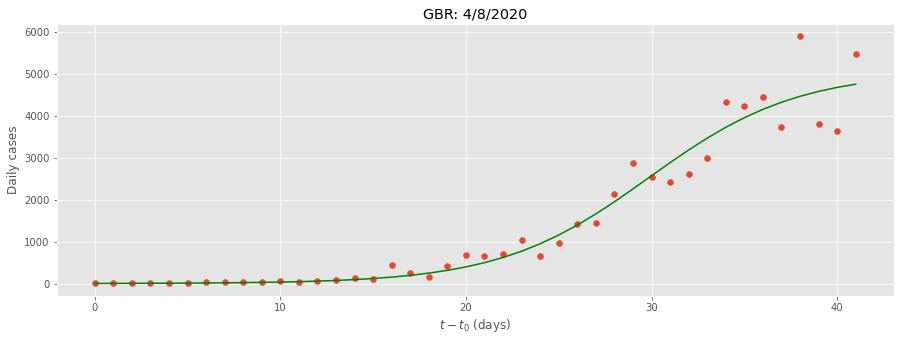

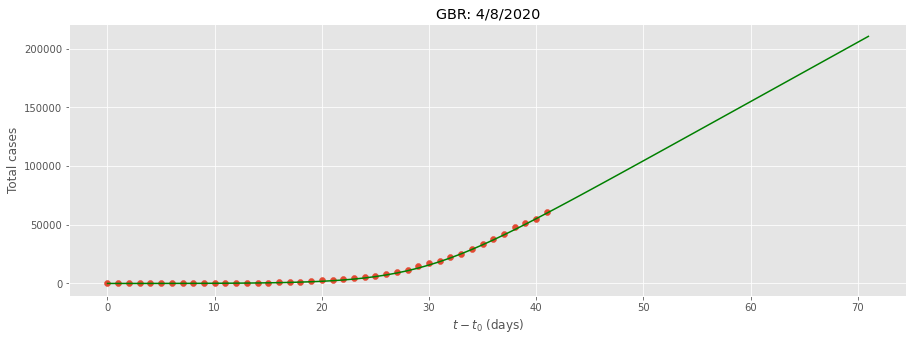

210476.1033392037


In [227]:
def daily_fit(t,t1,dt,dn):
    a=0.25
    t2=t1+dt
    return dn*(1./(1.+np.exp(-a*(t-t1))) - 1./(1.+np.exp(-a*(t-t2))))

fit_and_print('GBR', daily, t0, pops)

[  31.54495731   11.70668769 6960.02654558]
5.273424396068667


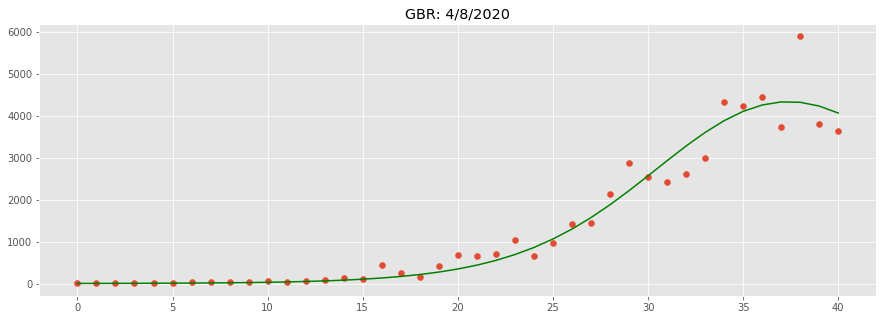

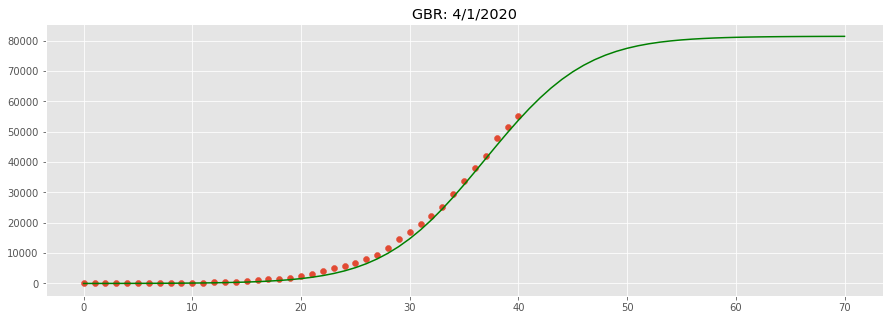

81441.23936172047


In [170]:
# CHN data and parapmeters

# def daily_fit(t,t1,dt,dn):
#     a=0.25
#     t2=t1+dt
#     return dn*(1./(1.+np.exp(-a*(t-t1))) - 1./(1.+np.exp(-a*(t-t2))))

# fdat = daily_GBR
# xdat = np.arange(len(fdat))
    
# popt, pcov = curve_fit(daily_fit, xdat, fdat)
# print(popt)
# t1=popt[0]
# dt=popt[1]
# dn=popt[2]

# #t1 = 28
# #dt = 20

# ffit=daily_fit(xdat, t1, dt, dn)

# rmsfit=np.sqrt(np.sum((ffit-fdat)**2)/len(fdat))
# print(rmsfit/dn*100)

# plt.figure(figsize=(15,5))
# plt.scatter(xdat,fdat)
# plt.plot(xdat,ffit,'g')
# plt.title('GBR: 4/8/2020')
# plt.show();

# T_ext=30
# cumm_dat=np.zeros(len(fdat))
# xdat_ext = np.arange(len(fdat)+T_ext)
# ffit_ext=daily_fit(xdat_ext, t1, dt, dn)
# cumm_fit=np.zeros(len(fdat)+T_ext)
# cumm_dat[0]=fdat[0]
# cumm_fit[0]=ffit[0]
# for i in range (1,len(fdat)):
#     cumm_dat[i]=cumm_dat[i-1]+fdat[i]
# for i in range (1,len(fdat)+T_ext):
#     cumm_fit[i]=cumm_fit[i-1]+ffit_ext[i]
# plt.figure(figsize=(15,5))
# plt.scatter(xdat,cumm_dat)
# plt.plot(xdat_ext,cumm_fit,'g')
# plt.title('GBR: 4/1/2020')
# plt.show();

# print(cumm_fit[-1])

[ 26.67386234 856.56544731 466.42918704]
14.422754358161555


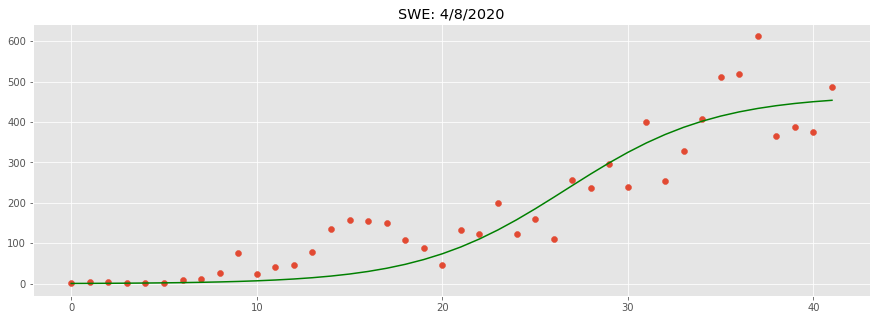

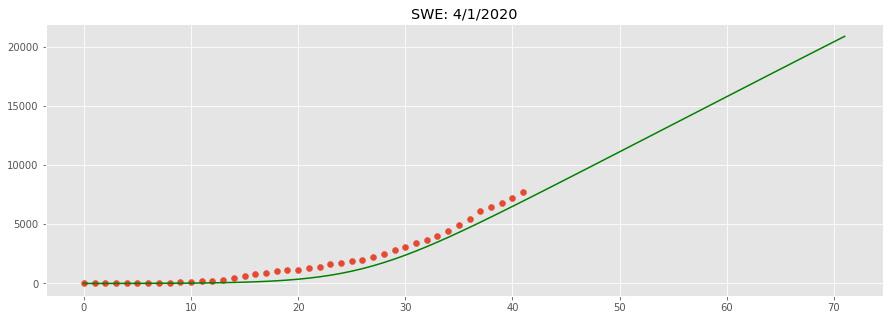

20864.718547907818


In [110]:
# CHN data and parapmeters

fdat = daily_SWE
xdat = np.arange(len(fdat))
    
popt, pcov = curve_fit(daily_fit, xdat, fdat)
print(popt)
t1=popt[0]
dt=popt[1]
dn=popt[2]

dt = 60

ffit=daily_fit(xdat, t1, dt, dn)

rmsfit=np.sqrt(np.sum((ffit-fdat)**2)/len(fdat))
print(rmsfit/dn*100)

plt.figure(figsize=(15,5))
plt.scatter(xdat,fdat)
plt.plot(xdat,ffit,'g')
plt.title('SWE: 4/8/2020')
plt.show();

T_ext=30
cumm_dat=np.zeros(len(fdat))
xdat_ext = np.arange(len(fdat)+T_ext)
ffit_ext=daily_fit(xdat_ext, t1, dt, dn)
cumm_fit=np.zeros(len(fdat)+T_ext)
cumm_dat[0]=fdat[0]
cumm_fit[0]=ffit[0]
for i in range (1,len(fdat)):
    cumm_dat[i]=cumm_dat[i-1]+fdat[i]
for i in range (1,len(fdat)+T_ext):
    cumm_fit[i]=cumm_fit[i-1]+ffit_ext[i]
plt.figure(figsize=(15,5))
plt.scatter(xdat,cumm_dat)
plt.plot(xdat_ext,cumm_fit,'g')
plt.title('SWE: 4/1/2020')
plt.show();

print(cumm_fit[-1])

[  22.43118808   19.10278995 1331.90500852]
12.101755897809264


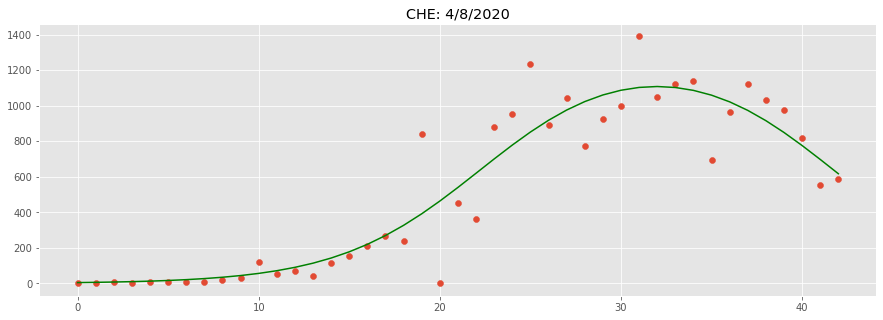

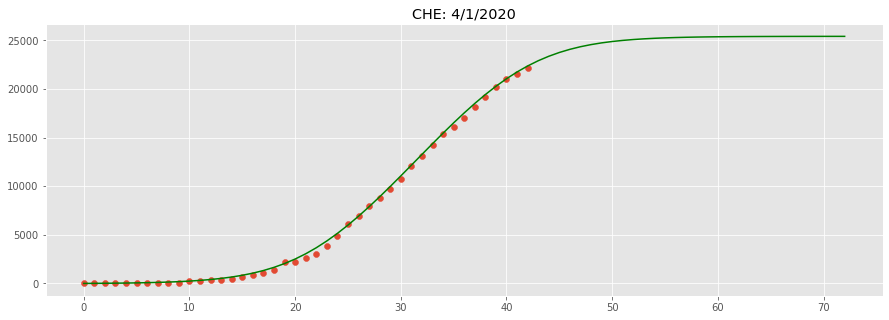

25423.77981401712


In [111]:
# CHN data and parapmeters

fdat = daily_CHE
xdat = np.arange(len(fdat))
    
popt, pcov = curve_fit(daily_fit, xdat, fdat)
print(popt)
t1=popt[0]
dt=popt[1]
dn=popt[2]

#dt=23

ffit=daily_fit(xdat, t1, dt, dn)

rmsfit=np.sqrt(np.sum((ffit-fdat)**2)/len(fdat))
print(rmsfit/dn*100)

plt.figure(figsize=(15,5))
plt.scatter(xdat,fdat)
plt.plot(xdat,ffit,'g')
plt.title('CHE: 4/8/2020')
plt.show();

T_ext=30
cumm_dat=np.zeros(len(fdat))
xdat_ext = np.arange(len(fdat)+T_ext)
ffit_ext=daily_fit(xdat_ext, t1, dt, dn)
cumm_fit=np.zeros(len(fdat)+T_ext)
cumm_dat[0]=fdat[0]
cumm_fit[0]=ffit[0]
for i in range (1,len(fdat)):
    cumm_dat[i]=cumm_dat[i-1]+fdat[i]
for i in range (1,len(fdat)+T_ext):
    cumm_fit[i]=cumm_fit[i-1]+ffit_ext[i]
plt.figure(figsize=(15,5))
plt.scatter(xdat,cumm_dat)
plt.plot(xdat_ext,cumm_fit,'g')
plt.title('CHE: 4/1/2020')
plt.show();

print(cumm_fit[-1])

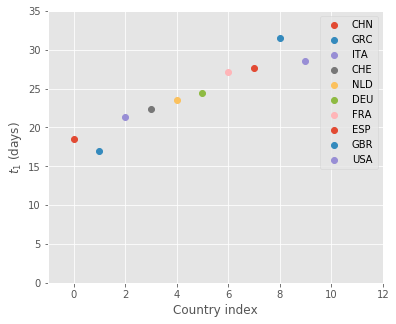

In [34]:
t1_ten=np.zeros(10)
x=np.arange(10)
t1_ten[7]=27.7
t1_ten[2]=21.4
t1_ten[4]=23.5
t1_ten[5]=24.5
t1_ten[6]=27.1
t1_ten[1]=17.0
t1_ten[0]=18.5
t1_ten[9]=28.6
t1_ten[8]=31.5
t1_ten[3]=22.4

fig=plt.figure(figsize=(6,5))
plt.plot(x[0],t1_ten[0],'o',label='CHN')
plt.plot(x[1],t1_ten[1],'o',label='GRC')
plt.plot(x[2],t1_ten[2],'o',label='ITA')
plt.plot(x[3],t1_ten[3],'o',label='CHE')
plt.plot(x[4],t1_ten[4],'o',label='NLD')
plt.plot(x[5],t1_ten[5],'o',label='DEU')
plt.plot(x[6],t1_ten[6],'o',label='FRA')
plt.plot(x[7],t1_ten[7],'o',label='ESP')
plt.plot(x[8],t1_ten[8],'o',label='GBR')
plt.plot(x[9],t1_ten[9],'o',label='USA')
plt.xlabel('Country index')
plt.ylabel('$t_1$ (days)')
plt.ylim(0,35)
plt.xlim(-1,12)
plt.legend()
plt.show()
fig.savefig('t1_10.png',format='png')


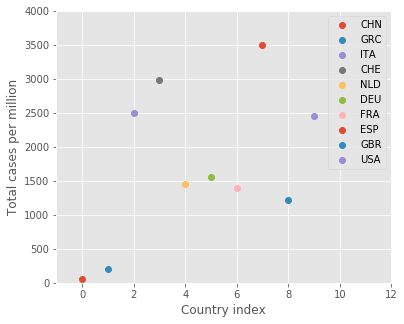

In [35]:
Nt_ten=np.zeros(10)
x=np.arange(10)
Nt_ten[0]=81054
Nt_ten[1]=2210
Nt_ten[2]=150900
Nt_ten[3]=25424
Nt_ten[4]=25150
Nt_ten[5]=128900
Nt_ten[6]=93100
Nt_ten[7]=163750
Nt_ten[8]=81440
Nt_ten[9]=802000

fig=plt.figure(figsize=(6,5))
plt.plot(x[0],Nt_ten[0]/popul_CHN*1.0e6,'o',label='CHN')
plt.plot(x[1],Nt_ten[1]/popul_GRC*1.0e6,'o',label='GRC')
plt.plot(x[2],Nt_ten[2]/popul_ITA*1.0e6,'o',label='ITA')
plt.plot(x[3],Nt_ten[3]/popul_CHE*1.0e6,'o',label='CHE')
plt.plot(x[4],Nt_ten[4]/popul_NLD*1.0e6,'o',label='NLD')
plt.plot(x[5],Nt_ten[5]/popul_DEU*1.0e6,'o',label='DEU')
plt.plot(x[6],Nt_ten[6]/popul_FRA*1.0e6,'o',label='FRA')
plt.plot(x[7],Nt_ten[7]/popul_ESP*1.0e6,'o',label='ESP')
plt.plot(x[8],Nt_ten[8]/popul_GBR*1.0e6,'o',label='GBR')
plt.plot(x[9],Nt_ten[9]/popul_USA*1.0e6,'o',label='USA')
plt.ylim(0,4000)
plt.xlim(-1,12)
plt.xlabel('Country index')
plt.ylabel('Total cases per million')
plt.legend()
plt.show()
fig.savefig('Nt_10.png',format='png')